<a href="https://colab.research.google.com/github/abhipavi/SRGAN/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cv2
import math
from google.colab.patches import cv2_imshow
import glob
from PIL import Image
from collections import OrderedDict
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.experimental.preprocessing import Resizing
from keras.layers import UpSampling2D
from keras.layers import add

Mount google drive to colab notebook

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')  #moount google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading pre-processed data into arrays

In [ ]:
x_train_arr = np.load('/content/gdrive/My Drive/MajorProject/BSD/x_train_arr.npy')
x_test_arr = np.load('/content/gdrive/My Drive/MajorProject/BSD/x_test_arr.npy')
x_val_arr = np.load('/content/gdrive/My Drive/MajorProject/BSD/x_val_arr.npy')

y_train_arr = np.load('/content/gdrive/My Drive/MajorProject/BSD/y_train_arr.npy')
y_test_arr = np.load('/content/gdrive/My Drive/MajorProject/BSD/y_test_arr.npy')
y_val_arr = np.load('/content/gdrive/My Drive/MajorProject/BSD/y_val_arr.npy')

#Callbacks

In [ ]:
class SRCallback(keras.callbacks.Callback):
  def __init__(self):
    super(SRCallback,self).__init__()

  def on_epoch_begin(self,epoch,logs=None):
    self.psnr = []

  def on_test_batch_end(self,batch,logs=None):
    self.psnr.append(10*math.log10(254**2/logs["loss"]))
  
  def on_epoch_end(self,epoch,logs=None):
    print('Mean PSNR for epoch %.2f' % (np.mean(self.psnr)))

callbacks = [SRCallback()]

# SRCNN
Super Resolution CNN

In [ ]:
#SRCNN Model
model_c = tf.keras.models.Sequential([
                                   tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(160,240,3)),
                                   tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
                                   tf.keras.layers.experimental.preprocessing.Resizing(321,481,interpolation='bilinear'),
                                   tf.keras.layers.Conv2D(3,(3,3),activation='relu',padding='same')
              
])

In [ ]:
model_c.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
model_c.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 240, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 240, 32)      18464     
_________________________________________________________________
resizing (Resizing)          (None, 321, 481, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 321, 481, 3)       867       
Total params: 21,123
Trainable params: 21,123
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_c = model_c.fit(x_train_arr,y_train_arr,batch_size=32,epochs=150,verbose=2,callbacks=callbacks,validation_data=(x_val_arr,y_val_arr))

Epoch 1/150
Mean PSNR for epoch 17.64
11/11 - 2s - loss: 7197.5308 - accuracy: 0.2424 - val_loss: 1197.7679 - val_accuracy: 0.4389
Epoch 2/150
Mean PSNR for epoch 18.94
11/11 - 1s - loss: 1484.6475 - accuracy: 0.4157 - val_loss: 850.0234 - val_accuracy: 0.3991
Epoch 3/150
Mean PSNR for epoch 20.96
11/11 - 1s - loss: 776.8171 - accuracy: 0.5560 - val_loss: 539.7515 - val_accuracy: 0.6786
Epoch 4/150
Mean PSNR for epoch 22.57
11/11 - 1s - loss: 459.1571 - accuracy: 0.7460 - val_loss: 374.3175 - val_accuracy: 0.7292
Epoch 5/150
Mean PSNR for epoch 23.27
11/11 - 1s - loss: 341.0158 - accuracy: 0.8276 - val_loss: 316.6581 - val_accuracy: 0.7898
Epoch 6/150
Mean PSNR for epoch 23.62
11/11 - 1s - loss: 292.3200 - accuracy: 0.8474 - val_loss: 292.9604 - val_accuracy: 0.7948
Epoch 7/150
Mean PSNR for epoch 24.07
11/11 - 1s - loss: 263.9696 - accuracy: 0.8703 - val_loss: 263.5230 - val_accuracy: 0.8434
Epoch 8/150
Mean PSNR for epoch 24.38
11/11 - 1s - loss: 243.2231 - accuracy: 0.8949 - val_los

In [ ]:
score_c = model_c.evaluate(x_test_arr,y_test_arr,batch_size=32,verbose=1)

2/2 [==============================] - 0s 83ms/step - loss: 131.9948 - accuracy: 0.9280


In [ ]:
prediction_c = model_c.predict(x_test_arr)

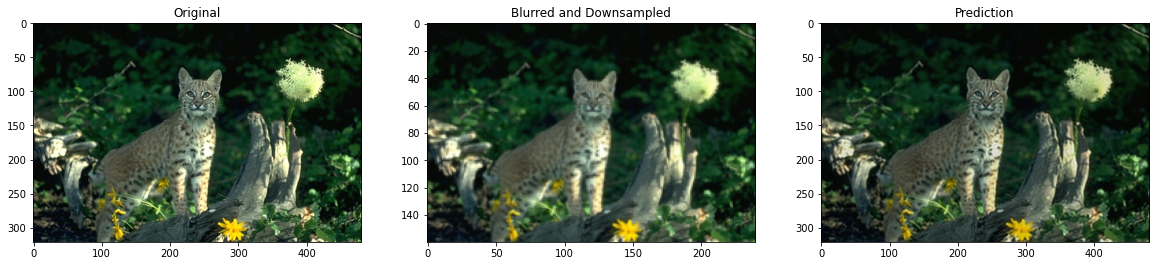

In [ ]:
f , (a,b,c) = plt.subplots(1,3)
f.set_figheight(5),f.set_figwidth(20)
c.set_title('Prediction'),b.set_title('Blurred and Downsampled'),a.set_title('Original')
c.imshow(prediction_c[0]/np.max(prediction_c[0])),b.imshow(x_test_arr[0]),a.imshow(y_test_arr[0])
plt.show()

# ESRCNN
Expanded SRCNN

In [ ]:
input  = tf.keras.Input(shape=(160,240,3),name='Img')
x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(input)
y_1 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(x)
y_2 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(x)
y_3 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(x)
x = tf.keras.layers.add([y_1,y_2,y_3])
x = tf.keras.layers.Conv2D(3,3,activation='relu',padding='same')(x)
output = tf.keras.layers.experimental.preprocessing.Resizing(321,481,interpolation='bilinear')(x)
model_esr = tf.keras.Model(input,output,name='ESRCNN')

In [ ]:
model_esr.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
model_esr.summary()

Model: "ESRCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Img (InputLayer)                [(None, 160, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 160, 240, 64) 1792        Img[0][0]                        
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 160, 240, 32) 18464       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 160, 240, 32) 18464       conv2d_3[0][0]                   
_____________________________________________________________________________________________

In [ ]:
history_esr = model_esr.fit(x_train_arr,y_train_arr,batch_size=32,epochs=150,verbose=2,callbacks=callbacks,validation_data=(x_val_arr,y_val_arr))

Epoch 1/150
Mean PSNR for epoch 19.33
11/11 - 1s - loss: 2157.9404 - accuracy: 0.4648 - val_loss: 779.7126 - val_accuracy: 0.5952
Epoch 2/150
Mean PSNR for epoch 21.81
11/11 - 1s - loss: 657.9015 - accuracy: 0.5974 - val_loss: 438.9244 - val_accuracy: 0.6071
Epoch 3/150
Mean PSNR for epoch 23.24
11/11 - 1s - loss: 369.8934 - accuracy: 0.7615 - val_loss: 318.1685 - val_accuracy: 0.8203
Epoch 4/150
Mean PSNR for epoch 24.12
11/11 - 1s - loss: 281.9419 - accuracy: 0.8409 - val_loss: 260.9049 - val_accuracy: 0.8511
Epoch 5/150
Mean PSNR for epoch 24.60
11/11 - 1s - loss: 238.2262 - accuracy: 0.8733 - val_loss: 233.5421 - val_accuracy: 0.8533
Epoch 6/150
Mean PSNR for epoch 24.97
11/11 - 1s - loss: 213.2691 - accuracy: 0.8913 - val_loss: 214.6015 - val_accuracy: 0.8758
Epoch 7/150
Mean PSNR for epoch 25.19
11/11 - 1s - loss: 199.6530 - accuracy: 0.9002 - val_loss: 204.1277 - val_accuracy: 0.8860
Epoch 8/150
Mean PSNR for epoch 25.32
11/11 - 1s - loss: 192.1407 - accuracy: 0.9054 - val_loss:

In [ ]:
score_esr = model_esr.evaluate(x_test_arr,y_test_arr,batch_size=32,verbose=1)

2/2 [==============================] - 0s 21ms/step - loss: 160.4205 - accuracy: 0.9282


In [ ]:
prediction_esr = model_esr.predict(x_test_arr)

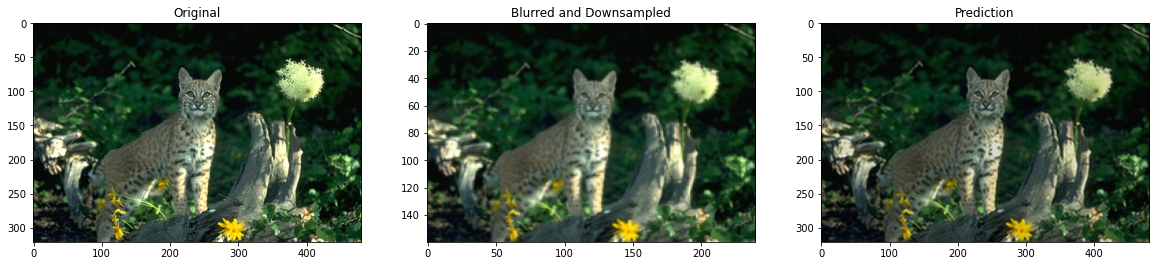

In [ ]:
f , (a,b,c) = plt.subplots(1,3)
f.set_figheight(5),f.set_figwidth(20)
c.set_title('Prediction'),b.set_title('Blurred and Downsampled'),a.set_title('Original')
c.imshow(prediction_esr[0]/np.max(prediction_esr[0])),b.imshow(x_test_arr[0]),a.imshow(y_test_arr[0])
plt.show()

# DSRCNN
Denoiseing SRCNN

In [ ]:
#DSRCNN Model
input = tf.keras.Input(shape=(160,240,3),name='Img')
x = tf.keras.layers.experimental.preprocessing.Resizing(321,481,interpolation='bilinear')(input)
x = tf.keras.layers.Conv2D(64,3,activation = 'relu',padding='same')(x)
y = tf.keras.layers.Conv2D(64,3,activation = 'relu',padding='same')(x)
z = tf.keras.layers.Conv2DTranspose(64,3,activation='relu',padding='same')(y)
z = tf.keras.layers.add([z,y])       #Merge Layer
z = tf.keras.layers.Conv2DTranspose(64,3,activation='relu',padding='same')(z)
z = tf.keras.layers.add([z,x])
z = tf.keras.layers.Conv2D(3,3,activation='relu',padding='same')(z)
model_dsr = tf.keras.Model(input,z,name='DSRCNN')

In [ ]:
model_dsr.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
model_dsr.summary()

Model: "DSRCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Img (InputLayer)                [(None, 160, 240, 3) 0                                            
__________________________________________________________________________________________________
resizing_2 (Resizing)           (None, 321, 481, 3)  0           Img[0][0]                        
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 321, 481, 64) 1792        resizing_2[0][0]                 
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 321, 481, 64) 36928       conv2d_8[0][0]                   
_____________________________________________________________________________________________

In [ ]:
history_dsr = model_dsr.fit(x_train_arr,y_train_arr,batch_size=32,epochs=150,verbose=2,callbacks=callbacks,validation_data=(x_val_arr,y_val_arr))

Epoch 1/150
Mean PSNR for epoch 19.45
11/11 - 8s - loss: 3916.3665 - accuracy: 0.3830 - val_loss: 786.5948 - val_accuracy: 0.4465
Epoch 2/150
Mean PSNR for epoch 21.95
11/11 - 6s - loss: 597.8195 - accuracy: 0.5978 - val_loss: 428.0164 - val_accuracy: 0.5967
Epoch 3/150
Mean PSNR for epoch 23.43
11/11 - 6s - loss: 371.1456 - accuracy: 0.6975 - val_loss: 304.5219 - val_accuracy: 0.7533
Epoch 4/150
Mean PSNR for epoch 24.11
11/11 - 6s - loss: 282.1675 - accuracy: 0.7992 - val_loss: 261.2546 - val_accuracy: 0.7775
Epoch 5/150
Mean PSNR for epoch 24.51
11/11 - 6s - loss: 230.5849 - accuracy: 0.8707 - val_loss: 238.7739 - val_accuracy: 0.8446
Epoch 6/150
Mean PSNR for epoch 25.29
11/11 - 6s - loss: 207.6456 - accuracy: 0.9011 - val_loss: 199.9407 - val_accuracy: 0.8877
Epoch 7/150
Mean PSNR for epoch 25.60
11/11 - 6s - loss: 185.1081 - accuracy: 0.9097 - val_loss: 186.2952 - val_accuracy: 0.8819
Epoch 8/150
Mean PSNR for epoch 25.85
11/11 - 6s - loss: 177.1769 - accuracy: 0.9091 - val_loss:

In [ ]:
score_dsr = model_dsr.evaluate(x_test_arr,y_test_arr,batch_size=32,verbose=1)

2/2 [==============================] - 1s 277ms/step - loss: 124.2474 - accuracy: 0.8864


In [ ]:
prediction_dsr = model_dsr.predict(x_test_arr)

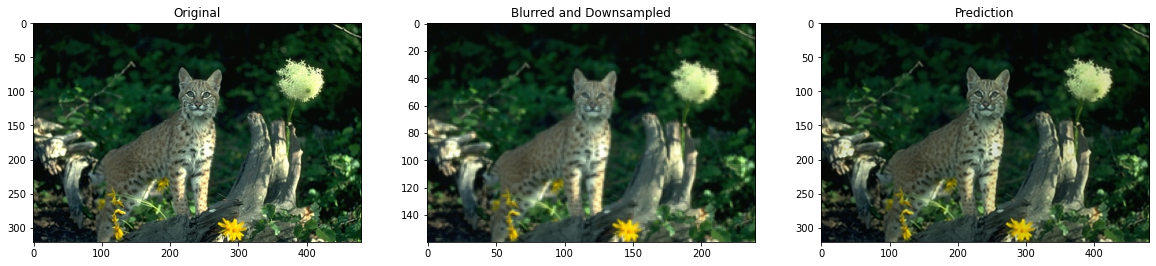

In [ ]:
f , (a,b,c) = plt.subplots(1,3)
f.set_figheight(5),f.set_figwidth(20)
c.set_title('Prediction'),b.set_title('Blurred and Downsampled'),a.set_title('Original')
c.imshow(prediction_dsr[0]/np.max(prediction_dsr[0])),b.imshow(x_test_arr[0]),a.imshow(y_test_arr[0])
plt.show()


# DDSRCNN
Deep Denoiseing SRCNN

In [ ]:
input = tf.keras.Input(shape=(160,240,3),name='Img')
x = Resizing(320,480,interpolation='bilinear')(input)
x = Conv2D(64,3,activation='relu',padding='same')(x)
x = Conv2D(64,3,activation='relu',padding='same')(x)
y = MaxPooling2D(pool_size=(2,2),padding='same')(x)
y = Conv2D(128,3,activation='relu',padding='same')(y)
y = Conv2D(128,3,activation='relu',padding='same')(y)
z = MaxPooling2D(pool_size=(2,2),padding='same')(y)
z = Conv2D(256,3,activation='relu',padding='same')(z)
z = UpSampling2D(size=(2,2),interpolation='bilinear')(z)
z = Conv2D(128,3,activation='relu',padding='same')(z)
z = Conv2D(128,3,activation='relu',padding='same')(z)
z = add([z,y])
z = UpSampling2D(size=(2,2),interpolation='bilinear')(z)
z = Conv2D(64,3,activation='relu',padding='same')(z)
z = Conv2D(64,3,activation='relu',padding='same')(z)
z = add([z,x])
z = Resizing(321,481,interpolation='bilinear')(z)
output = Conv2D(3,3,activation='relu',padding='same')(z)

model_ddsr = tf.keras.Model(input,output,name='DDSRCNN')

In [ ]:
model_ddsr.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
model_ddsr.summary()

Model: "DDSRCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Img (InputLayer)                [(None, 160, 240, 3) 0                                            
__________________________________________________________________________________________________
resizing_5 (Resizing)           (None, 320, 480, 3)  0           Img[0][0]                        
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 320, 480, 64) 1792        resizing_5[0][0]                 
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 320, 480, 64) 36928       conv2d_21[0][0]                  
____________________________________________________________________________________________

In [ ]:
history_ddsr = model_ddsr.fit(x_train_arr,y_train_arr,batch_size=20,epochs=150,verbose=2,callbacks=callbacks,validation_data=(x_val_arr,y_val_arr))

Epoch 1/150
Mean PSNR for epoch 18.72
18/18 - 17s - loss: 4832.6094 - accuracy: 0.4493 - val_loss: 902.4866 - val_accuracy: 0.3974
Epoch 2/150
Mean PSNR for epoch 23.05
18/18 - 15s - loss: 494.4547 - accuracy: 0.7037 - val_loss: 327.0872 - val_accuracy: 0.9092
Epoch 3/150
Mean PSNR for epoch 24.27
18/18 - 15s - loss: 277.4696 - accuracy: 0.8989 - val_loss: 247.7988 - val_accuracy: 0.8970
Epoch 4/150
Mean PSNR for epoch 24.85
18/18 - 15s - loss: 224.7191 - accuracy: 0.9105 - val_loss: 217.3097 - val_accuracy: 0.9120
Epoch 5/150
Mean PSNR for epoch 25.15
18/18 - 15s - loss: 198.9960 - accuracy: 0.9138 - val_loss: 202.8408 - val_accuracy: 0.8843
Epoch 6/150
Mean PSNR for epoch 25.41
18/18 - 15s - loss: 191.8428 - accuracy: 0.9184 - val_loss: 191.2152 - val_accuracy: 0.9199
Epoch 7/150
Mean PSNR for epoch 25.03
18/18 - 15s - loss: 181.7625 - accuracy: 0.9276 - val_loss: 208.5493 - val_accuracy: 0.8967
Epoch 8/150
Mean PSNR for epoch 25.69
18/18 - 15s - loss: 181.5318 - accuracy: 0.9241 - v

In [ ]:
score_ddsr = model_ddsr.evaluate(x_test_arr,y_test_arr,batch_size=20,verbose=1)

2/2 [==============================] - 1s 581ms/step - loss: 117.6549 - accuracy: 0.9189


In [ ]:
prediction_ddsr = model_ddsr.predict(x_test_arr)

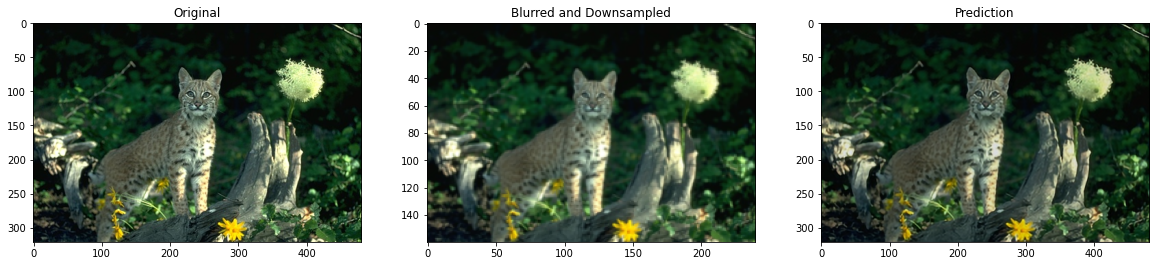

In [ ]:
f , (a,b,c) = plt.subplots(1,3)
f.set_figheight(5),f.set_figwidth(20)
c.set_title('Prediction'),b.set_title('Blurred and Downsampled'),a.set_title('Original')
c.imshow(prediction_ddsr[0]/np.max(prediction_ddsr[0])),b.imshow(x_test_arr[0]),a.imshow(y_test_arr[0])
plt.show()
